In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.utils.data.dataloader as dataloader
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [47]:
data_set_root = "../../datasets"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.MNIST(data_set_root,
                         train=True,
                         download=True,
                         transform=transform)

num_examples = 100
rand_perm = torch.randperm(dataset.data.shape[0])[:num_examples]

# Extract and concatenate the images of randomly selected examples into a tensor
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1, -1) for i in rand_perm])

In [48]:
dataset_tensor.shape

torch.Size([100, 784])

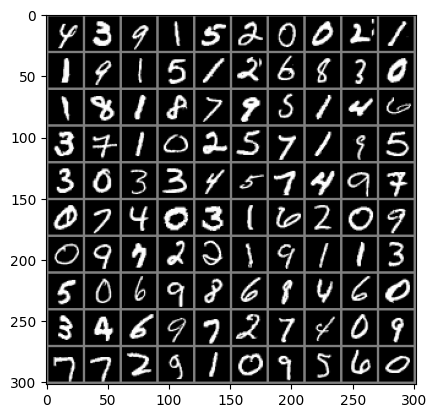

In [49]:
out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

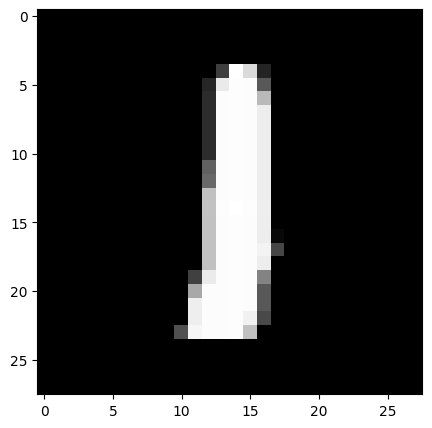

In [50]:
plt.figure(figsize = (5,5))
plt.imshow(dataset_tensor[10].reshape(28, 28).numpy(), cmap="gray")

Attention Formula:

$
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_{key}}})V
$

In [61]:
d_model = 32

# Random query vector
rand_q = torch.randn(1, d_model) # (1, d_model)

# Random key vector for each image in the dataset
rand_k = torch.randn(num_examples, d_model) # (num_examples, d_model)

# Calculate attention map
attention_map = torch.matmul(rand_q, rand_k.permute(1, 0)).float() # (1, num_examples)

# Use softmax to obtain a probabiltiy distribution of attention weights
attention_weights = F.softmax(attention_map, dim=-1)

# Use the attention weights as "soft indexing" by multiplying with value tensor
output = torch.matmul(attention_weights, dataset_tensor)

In [62]:
print(f"The largest Softmax value is {attention_map.max().item()}")

The largest Softmax value is 9.741734504699707


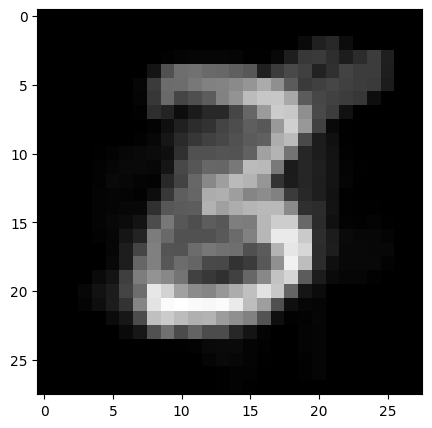

In [63]:
plt.figure(figsize=(5, 5))
plt.imshow(output.reshape(28, 28).numpy(), cmap="gray")

**Multiple Queries**

In [54]:
d_model = 32
num_q = 8

# Random query vector
rand_q = torch.randn(num_q, d_model) # (num_q, d_model)

# Random key vector for each image in the dataset
rand_k = torch.randn(num_examples, d_model) # (num_examples, d_model)

# Calculate attention map
attention_map = torch.matmul(rand_q, rand_k.permute(1, 0)).float() # (num_q, num_examples)

# Use softmax to obtain a probabiltiy distribution of attention weights
attention_weights = F.softmax(attention_map, dim=-1)

# Use the attention weights as "soft indexing" by multiplying with value tensor
output = torch.matmul(attention_weights, dataset_tensor)

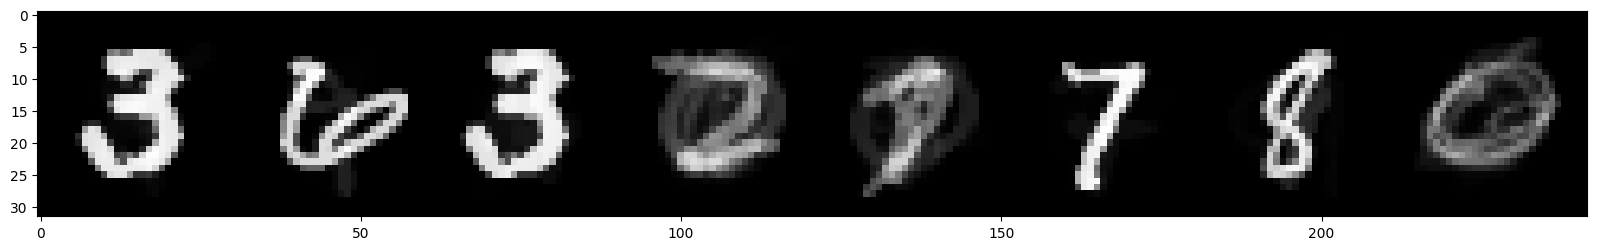

In [55]:
plt.figure(figsize=(20, 10))
out = torchvision.utils.make_grid(output.reshape(num_q, 1, 28, 28), 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

**Multi-Headed Attention**

In [56]:
d_model = 32
num_q = 8
num_heads = 4

# Random query vector
rand_q = torch.randn(num_heads, num_q, d_model) # (num_heads, num_q, d_model)

# Random key vector for each image in the dataset
rand_k = torch.randn(num_heads, num_examples, d_model) # (num_heads, num_examples, d_model)

# Calculate attention map
attention_map = torch.matmul(rand_q, rand_k.permute(0, 2, 1)).float() # (num_heads, num_q, num_examples)

# Use softmax to obtain a probabiltiy distribution of attention weights
attention_weights = F.softmax(attention_map, dim=-1)

# Use the attention weights as "soft indexing" by multiplying with value tensor
output = torch.matmul(attention_weights, dataset_tensor.unsqueeze(dim=0).expand(num_heads, num_examples, -1))

# Reshape the output tensor for visualization
out_reshape = output.reshape(num_heads, num_q, 28, 28).transpose(1, 2).reshape(num_heads, 1, 28, num_q * 28)

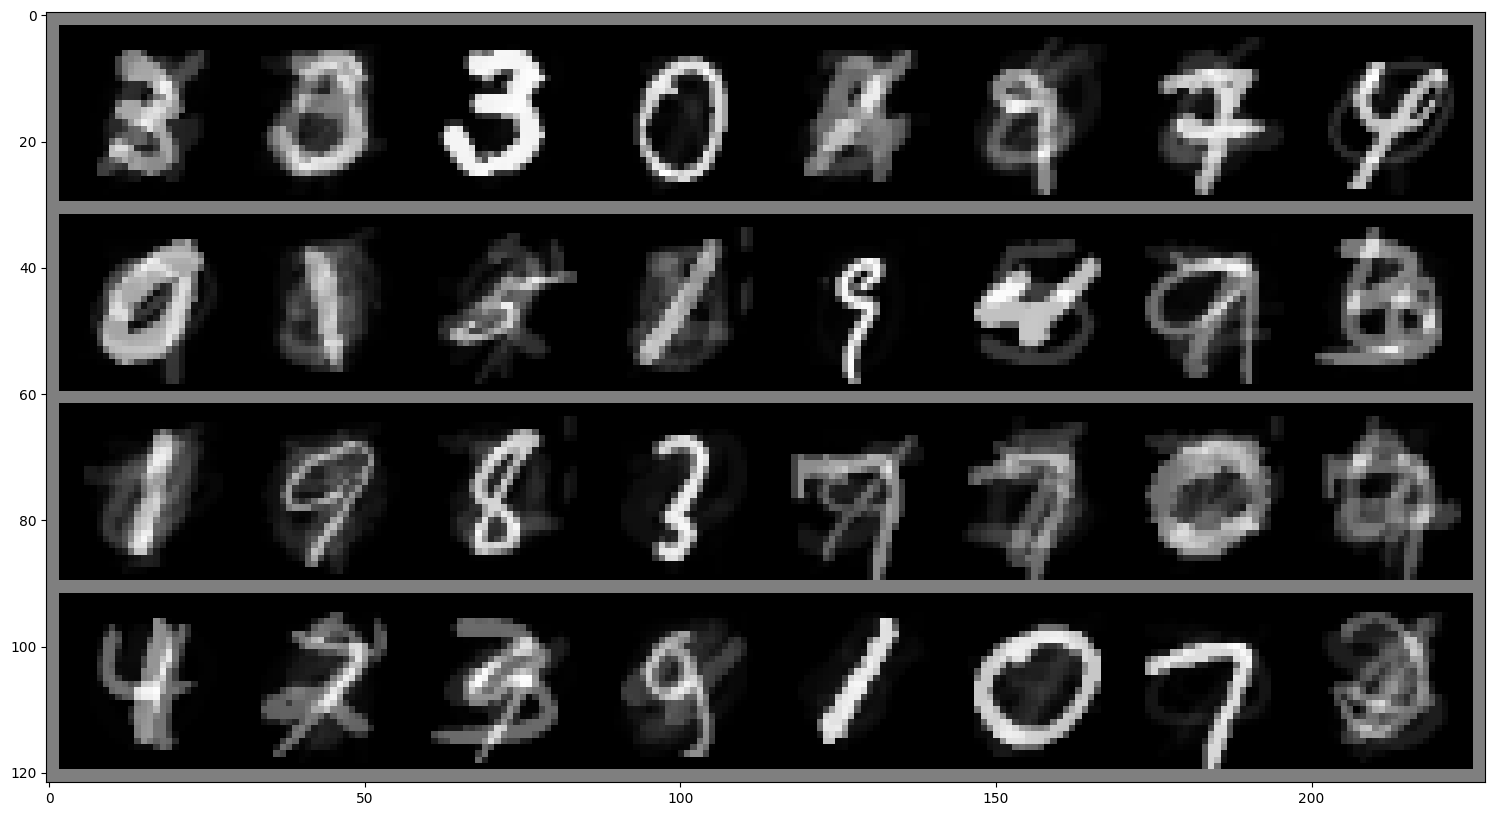

In [57]:
plt.figure(figsize=(20, 10))
out = torchvision.utils.make_grid(out_reshape, 1, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [67]:
d_model = 32
num_heads = 4
batch_size = 32

# Create random query, key, and value vectors
query = torch.randn(batch_size, 1, num_heads * d_model)
key = torch.randn(batch_size, num_examples, num_heads * d_model)
value = torch.randn(batch_size, num_examples, num_heads * d_model)

multi_head_attention = nn.MultiheadAttention(num_heads * d_model, num_heads, batch_first=True)

attn_output, attn_output_weights = multi_head_attention(query, key, value, average_attn_weights=False)

print("Softmax Attention Mask:", attn_output_weights.shape)
print("Attention Output:", attn_output.shape)
print("Projection weight size", multi_head_attention.in_proj_weight.shape)

Softmax Attention Mask: torch.Size([32, 4, 1, 100])
Attention Output: torch.Size([32, 1, 128])
Projection weight size torch.Size([384, 128])


In [68]:
class AttentionTest(nn.Module):
  def __init__(self, num_examples=100,
               d_model=784,
               num_heads=4):
    super().__init__()

    self.img_mlp = nn.Sequential(
        nn.Linear(784, d_model),
        nn.LayerNorm(d_model),
        nn.ELU(),
        nn.Linear(d_model, d_model)
    )

    self.mha = nn.MultiheadAttention(
        embed_dim=d_model,
        num_heads=num_heads,
        batch_first=True
    )

  def forward(self, img, values):
    img_ = self.img_mlp(img)
    values_ = self.img_mlp(values)

    attn_output, attn_output_weights = self.mha(img_, values_, values_)
    output = torch.matmul(attn_output_weights, values)

    return output, attn_output_weights

In [74]:
d_model = 256
num_heads = 1
batch_size = 64
lr = 1e-4
num_workers = os.cpu_count()

train_loader = dataloader.DataLoader(
    dataset,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True
)

In [76]:
model = AttentionTest(
    num_examples=num_examples,
    d_model=d_model,
    num_heads=num_heads
).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

values_tensor = dataset_tensor.unsqueeze(0).expand(batch_size, num_examples, -1).to(device)

In [77]:
model.train()

for i in trange(10, leave=False):
  for img, label in tqdm(train_loader, leave=False):
    q_img = img.reshape(img.shape[0], 1, -1).to(device) # (batch_size, 1, image_size * image_size)

    attn_output, attn_output_weights = model(q_img, values_tensor)

    loss = loss_fn(attn_output, q_img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

  0%|          | 0/937 [00:00<?, ?it/s]

In [78]:
model.eval()

with torch.inference_mode():
  q_img = img.reshape(img.shape[0], 1, -1).to(device) # (batch_size, 1, image_size * image_size)

  attn_output, attn_output_weights = model(q_img, values_tensor)

In [79]:
# For a given input, use the attention map to find the "closest" value-data matches
index = 10
top10 = attn_output_weights[index, 0].argsort(descending=True)[:10]
top10_data = values_tensor[index, top10].cpu()

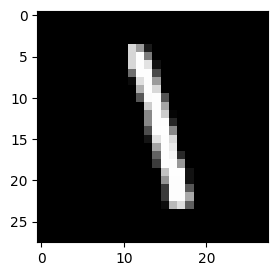

In [80]:
# Plot the original image
plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(q_img[index].cpu().reshape(-1, 1, 28, 28), 8, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

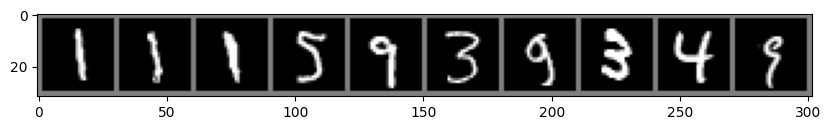

In [81]:
# Plot the top 10 closest matches
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(top10_data.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

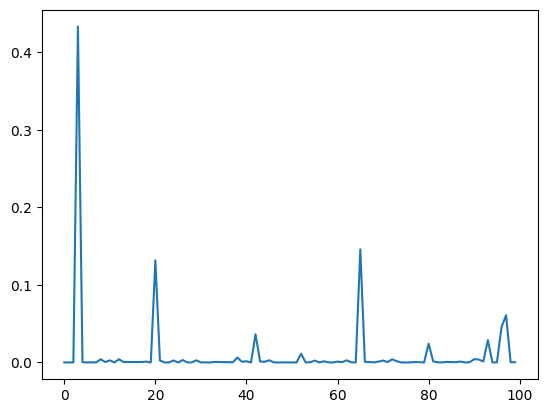

In [82]:
# Plot the attention weights for the given input
plt.plot(attn_output_weights[index, 0].cpu().numpy().flatten())

In [83]:
# Reshape the target and returned images
target_img = q_img.reshape(batch_size, 1, 28, 28)
indexed_img = attn_output.reshape(batch_size, 1, 28, 28)

# Stack the images with the returned image on top
img_pair = torch.cat((indexed_img, target_img), 2).cpu()

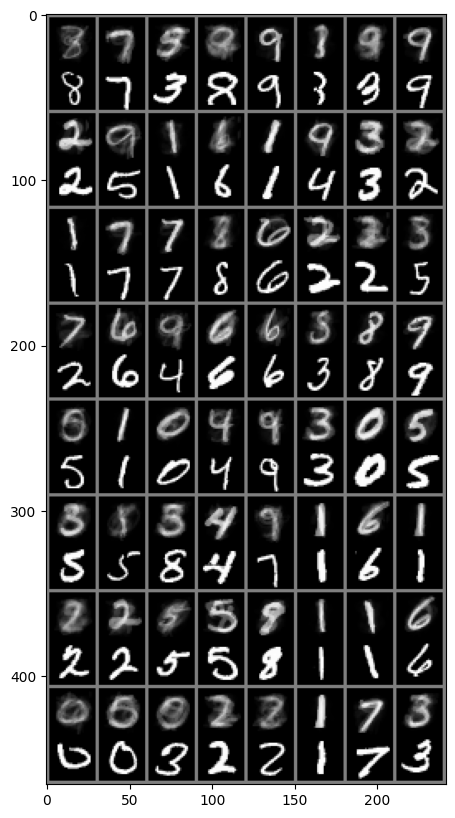

In [84]:
# Show the returned image and the target image
plt.figure(figsize=(10, 10))
out = torchvision.utils.make_grid(img_pair, 8, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))